<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221018/%5BExp_10%5D20221018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# exploration 10번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [59]:
import os
import numpy as np
import pandas as pd
import re
import string # 구두점 정규화 표현식

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

`tf.keras.preprocessing.text.Tokenizer` 는 더이상 사용하지 않으므로 `TextVectorization`로 변경<br>
`tensorflow.keras.preprocessing.sequence.pad_sequences`는 모듈 위치가 변경되었으므로
`tf.keras.utils.pad_sequences`로 변경<br>

## 상수선언

In [63]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/translator_seq2seq" # 데이터 기본경로
DATA_PATH  = BASE_PATH + "/data/fra.txt" # 사전 기본

SOS_TOKEN = '<sos>' # 문장 시작토큰
EOS_TOKEN = '<eos>' # 문장 끝 토큰

MAX_SAMPLE_LEN = 100000 # 최대 단어갯수
PUNCTUATION_REGEX = r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]' # 정규화
FRENCH_WHITESPACE = r'[\xa0\u202f\u2009]' # whitespace 정규화(1/4 whitespace 등의 대응)
FRENCH_APOSTROPHE = r"’" # 프랑스어 '
FRENCH_DOUBLE_COMMA = r"'<<|>>'" # 프랑스어 "
FRENCE_PUNCTUATION_REGEX = r"\—"

pad_seq_kwargs = {
    "value":None # 추후 추가예정
    , "padding":"post"
    , "maxlen":None # 추후 추가예정
}
TRAIN_TEST_SPLIT_KWARGS = {
    "test_size":0.4, "random_state":2022
}
fit_kwargs = {
    "epochs":15 # epoch 횟수
    , "batch_size":512
    ,"validation_data": None # 추후 추가예정
    , "shuffle" : True # epoch당 셔플을 할지의 여부
    , "verbose":1
}

`string.punctuation`의 구두점을 활용하여 만들었다.

In [62]:
print(
    re.sub('<<|>>', '"', '<<<abc>>><>')
)

"<abc"><>


## 메인

### IMDB 데이터셋

In [9]:
lines = pd.read_csv(DATA_PATH, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력
lines.pop('cc')
lines = lines.head(MAX_SAMPLE_LEN)

전체 샘플의 수 : 197463


In [14]:
# print(lines["fra"][lines["fra"].str.find("’'  ") > 0])

57                                 J’ai gagné.
116                                 J’ai payé.
184                                  Va-t’en !
278                                  Va-t’en !
334                               J’ai promis.
                         ...                  
99035          Tom était à l’époque en prison.
99059    Tom n’avait pas le droit de conduire.
99337          Nous n’avions peur de personne.
99401            Nous n’y sommes pas préparés.
99402           Nous n’y sommes pas préparées.
Name: fra, Length: 636, dtype: object


데이터에 대한 설명은 아래와 같다.</br>
- eng: 영어문장
- fra: 영어 문장에 해당되는 프랑스 문장
- cc: 저작권 정보

저작권 정보는 데이터 분석에 사용되지 않으므로 로드하지 않았다.

In [262]:
# 구두점(Punctuation)을 단어와 분리
# 프랑스 문법에만 존제하는 whitespace -> 표준 whitespace로 변경

lines["fra"] = lines["fra"].str.replace(FRENCH_WHITESPACE, r' ', regex=True)
lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True).replace(' +', ' ', regex=True).str.strip()
lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True).replace(' +', ' ', regex=True).str.strip()

lines["fra"] = f'{SOS_TOKEN} '+ lines["fra"] + f' {EOS_TOKEN}' # 양옆에 문장의 시작과 끝의 테그를 붙인다.

eng_tokenizer = Tokenizer(filters="")  # 문자 단위로 Tokenizer를 생성 
eng_tokenizer.fit_on_texts(lines["eng"])
encoder_input = eng_tokenizer.texts_to_sequences(lines["eng"])

fra_tokenizer = Tokenizer(filters="")
fra_tokenizer.fit_on_texts(lines["fra"])
target_text = fra_tokenizer.texts_to_sequences(lines["fra"])

eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

max_eng_seq_len = max(map(len, encoder_input))
max_fra_seq_len = max(map(len, target_text))
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 단어장의 크기 : 9021
프랑스어 단어장의 크기 : 18316
영어 시퀀스의 최대 길이 12
프랑스어 시퀀스의 최대 길이 24


영어문장와 프랑스문장를 각각 tokenize한 뒤<br>
단어 사전의크기, 한 문장의 최대 단어 갯수를 확인<br>
이 데이터는 후에 padding에 사용할 예정이다.<br>
이번에는 구두점도 임배팅에 필요하므로 필터옵션을 통해 없어지지 않도록 설정하였다.<br>

In [264]:
eos_index = fra_tokenizer.word_index[EOS_TOKEN]
sos_index = fra_tokenizer.word_index[SOS_TOKEN]

# 종료 토큰 제거
decoder_input = [[ idx_char for idx_char in line if idx_char != eos_index ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ idx_char for idx_char in line if idx_char != sos_index ] for line in target_text]

In [266]:
fra_tokenizer.word_index.keys()

dict_keys(['<sos>', '<eos>', '.', "'", 'je', '-', '?', 'est', 'vous', 'pas', 'de', 'tom', 'il', 'ne', 'tu', 'le', 'j', 'que', 'a', 'à', 'ai', 'nous', 'n', 'la', 'ce', 'un', 'l', '!', 'en', 'c', 'suis', 'une', 'd', 'me', 'les', 'ça', ',', 'êtes', 'elle', 'moi', 't', 'tout', 'faire', 'y', 's', 'es', 'm', 'te', 'fait', 'qu', 'était', 'as', 'sont', 'qui', 'pour', 'ils', 'mon', 'avez', 'veux', 'des', 'très', 'être', 'se', 'peux', 'plus', 'pourquoi', 'du', 'cela', 'elles', 'dans', 'sommes', 'ici', 'votre', 'avec', 'été', 'toi', 'où', 'sais', 'aime', 'avons', 'comment', 'au', 'besoin', 'ma', 'bien', 'si', 'cette', 'on', 'personne', 'ton', 'ont', 'vraiment', 'là', 'dit', 'tous', 'air', 'pense', 'sur', 'lui', 'aller', 'peut', 'étais', 'son', 'va', 'jamais', 'temps', 'monde', 'faut', 'trop', 'bon', 'beaucoup', 'fais', 'train', 'rien', 'dois', 'maintenant', 'vais', 'maison', 'encore', 'peu', 'chose', 'mes', 'puis', 'quoi', 'comme', 'ta', 'quelque', 'toujours', 'français', 'et', 'voir', 'quelle', 

문장의 끝 토큰이 제거된 input과<br>
문장의 시작 토큰이 제거된 output을 생성

In [7]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (100000, 28)
프랑스어 입력데이터의 크기(shape) : (100000, 80)
프랑스어 출력데이터의 크기(shape) : (100000, 80)


각 언어의 최대 단어갯수에 맞춰 padding을 생성하였다.<br>
(`문장의 갯수`,`각 언어의 문장당 단어 최대갯수`)모양의 데이터가 생성되었다.


In [9]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (100000, 28, 54, 2)
프랑스어 입력데이터의 크기(shape) : (100000, 80, 76, 2)
프랑스어 출력데이터의 크기(shape) : (100000, 80, 76, 2)


 최대 길이를 `maxlen`으로 설정하였고 값은 (평균 + 2*표준편차)로 하여<br>
대부분의 문장이 학습이 가능하도록 설정하였다.  

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, **pad_seq_kwargs)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, **pad_seq_kwargs)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, **TRAIN_TEST_SPLIT_KWARGS)
fit_kwargs["validation_data"] = (X_val, y_val)

과적합 방지를 위해 학습과 점증을 2:8비율로 나누었다. 

### 한국어 Word2Vec 임베딩

In [ ]:
word_vectors = Word2VecKeyedVectors.load(MODEL_PATH).wv

# 임의의 가중치 적용
embedding_matrix = np.random.rand(MAX_NUM_WORDS, WORD_VECTOR_DIM)

# 이미 학습된 단어가 있는 경우 학습된 백터를 넣는다.
for i in range(4,MAX_NUM_WORDS):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]


기본에 학습된 모델을 로드 뒤, 같은 단어장에 가중치를 랜덤으로 적용 후,<br>
단어장 안에 학습된 단어가 존제하면 백터의 값을 대입한다.

In [ ]:
model_list = []
w2v_model_list = []

# max pooling만 존제하는 model 설계
maxpool_model = tf.keras.Sequential(name = "maxpool_model")
maxpool_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
maxpool_model.add(tf.keras.layers.GlobalMaxPooling1D())
maxpool_model.add(tf.keras.layers.Dense(8, activation='relu'))
maxpool_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(maxpool_model)

w2v_maxpool_model = tf.keras.Sequential(name = "w2v_maxpool_model")
w2v_maxpool_model.add(tf.keras.layers.Embedding(
                                    MAX_NUM_WORDS 
                                    , WORD_VECTOR_DIM 
                                    , embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                                    , input_length=maxlen 
                                    , trainable=True
                                 )
)
w2v_maxpool_model.add(tf.keras.layers.GlobalMaxPooling1D())
w2v_maxpool_model.add(tf.keras.layers.Dense(8, activation='relu'))
w2v_maxpool_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

w2v_model_list.append(w2v_maxpool_model)

max pooling만 존제하는 model 설계하였다.<br>
처음부터 학습하는 모델 `maxpool_model`<br>
기존에 학습된 데이터를 활용하는 `w2v_maxpool_model`<br>
로 나누어 설계하였다.

In [ ]:
# CNN 1d model 설계
CNN_model = tf.keras.Sequential(name = "CNN_model")
CNN_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(CNN_model)

w2v_CNN_model = tf.keras.Sequential(name = "w2v_CNN_model")
w2v_CNN_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, 
                                 WORD_VECTOR_DIM, 
                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
w2v_CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
w2v_CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
w2v_CNN_model.add(tf.keras.layers.MaxPooling1D(5))
w2v_CNN_model.add(tf.keras.layers.Dropout(rate=0.4))
w2v_CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
w2v_CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
w2v_CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
w2v_CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

w2v_model_list.append(w2v_CNN_model)

CNN을 1차원으로 변형하여 학습하는 model 설계하였다.<br>
처음부터 학습하는 모델 `CNN_model`<br>
기존에 학습된 데이터를 활용하는 `w2v_CNN_model`<br>
로 나누어 설계하였다.

In [ ]:
# RNN model 설계
RNN_model = tf.keras.Sequential(name = "RNN_model")
RNN_model.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(64, dropout=0.4))
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(RNN_model)

w2v_RNN_model = tf.keras.Sequential(name = "w2v_RNN_model")
w2v_RNN_model.add(tf.keras.layers.Embedding(
                                 MAX_NUM_WORDS
                                 , WORD_VECTOR_DIM 
                                 , embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                                 , input_length=maxlen 
                                 , trainable=True))
w2v_RNN_model.add(tf.keras.layers.LSTM(64, dropout=0.4))
w2v_RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
w2v_RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

w2v_model_list.append(w2v_RNN_model)

RNN model 설계하였다.<br>
처음부터 학습하는 모델 `RNN_model`<br>
기존에 학습된 데이터를 활용하는 `w2v_RNN_model`<br>
로 나누어 설계하였다.

maxpool_model start
Epoch 1/15
172/172 [==============================] - 2s 6ms/step - loss: 0.6788 - accuracy: 0.7189 - val_loss: 0.6505 - val_accuracy: 0.7898
Epoch 2/15
172/172 [==============================] - 1s 5ms/step - loss: 0.6001 - accuracy: 0.8061 - val_loss: 0.5453 - val_accuracy: 0.8066
Epoch 3/15
172/172 [==============================] - 1s 5ms/step - loss: 0.4908 - accuracy: 0.8235 - val_loss: 0.4534 - val_accuracy: 0.8181
Epoch 4/15
172/172 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8365 - val_loss: 0.4069 - val_accuracy: 0.8266
Epoch 5/15
172/172 [==============================] - 1s 5ms/step - loss: 0.3760 - accuracy: 0.8457 - val_loss: 0.3846 - val_accuracy: 0.8327
Epoch 6/15
172/172 [==============================] - 1s 5ms/step - loss: 0.3519 - accuracy: 0.8537 - val_loss: 0.3725 - val_accuracy: 0.8362
Epoch 7/15
172/172 [==============================] - 1s 5ms/step - loss: 0.3347 - accuracy: 0.8603 - val_loss: 0.3649 - val_acc

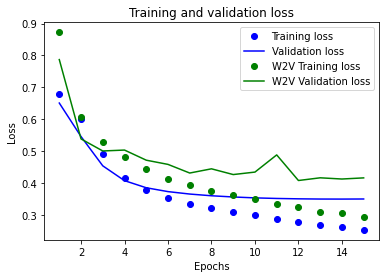

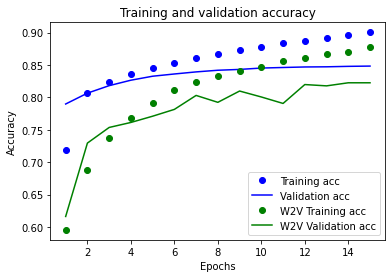

1537/1537 - 2s - loss: 0.3553 - accuracy: 0.8470 - 2s/epoch - 2ms/step
1537/1537 - 2s - loss: 0.4216 - accuracy: 0.8200 - 2s/epoch - 2ms/step
maxpool_model end

CNN_model start
Epoch 1/15
172/172 [==============================] - 3s 9ms/step - loss: 0.6918 - accuracy: 0.5287 - val_loss: 0.6840 - val_accuracy: 0.6766
Epoch 2/15
172/172 [==============================] - 1s 8ms/step - loss: 0.5862 - accuracy: 0.7169 - val_loss: 0.4533 - val_accuracy: 0.8019
Epoch 3/15
172/172 [==============================] - 1s 7ms/step - loss: 0.4315 - accuracy: 0.8065 - val_loss: 0.3946 - val_accuracy: 0.8256
Epoch 4/15
172/172 [==============================] - 1s 7ms/step - loss: 0.3941 - accuracy: 0.8272 - val_loss: 0.3773 - val_accuracy: 0.8357
Epoch 5/15
172/172 [==============================] - 1s 8ms/step - loss: 0.3742 - accuracy: 0.8397 - val_loss: 0.3682 - val_accuracy: 0.8400
Epoch 6/15
172/172 [==============================] - 1s 8ms/step - loss: 0.3586 - accuracy: 0.8476 - val_loss: 0

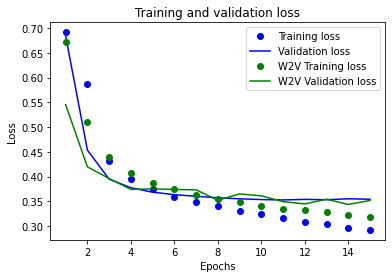

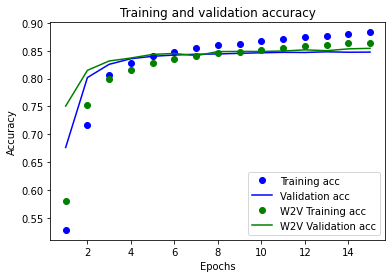

1537/1537 - 3s - loss: 0.3570 - accuracy: 0.8451 - 3s/epoch - 2ms/step
1537/1537 - 3s - loss: 0.3547 - accuracy: 0.8501 - 3s/epoch - 2ms/step
CNN_model end

RNN_model start
Epoch 1/15
172/172 [==============================] - 4s 12ms/step - loss: 0.6609 - accuracy: 0.5578 - val_loss: 0.4499 - val_accuracy: 0.7945
Epoch 2/15
172/172 [==============================] - 2s 9ms/step - loss: 0.4164 - accuracy: 0.8110 - val_loss: 0.3828 - val_accuracy: 0.8305
Epoch 3/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3753 - accuracy: 0.8348 - val_loss: 0.3743 - val_accuracy: 0.8384
Epoch 4/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3570 - accuracy: 0.8440 - val_loss: 0.3652 - val_accuracy: 0.8390
Epoch 5/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3455 - accuracy: 0.8507 - val_loss: 0.3663 - val_accuracy: 0.8416
Epoch 6/15
172/172 [==============================] - 2s 9ms/step - loss: 0.3370 - accuracy: 0.8544 - val_loss: 0.38

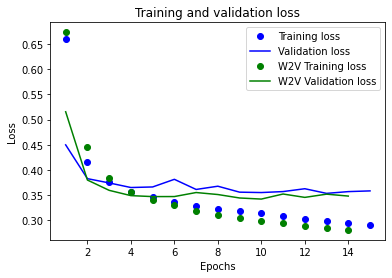

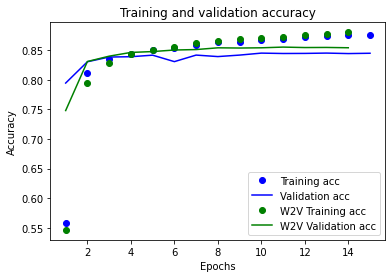

1537/1537 - 4s - loss: 0.3648 - accuracy: 0.8407 - 4s/epoch - 2ms/step
1537/1537 - 4s - loss: 0.3524 - accuracy: 0.8533 - 4s/epoch - 3ms/step
RNN_model end



In [ ]:
for model, w2v_model in zip(model_list,w2v_model_list):
    print(f"{model.name} start")

    # 모델 훈련
    model.compile(optimizer=tf.keras.optimizers.Nadam(
                        learning_rate=0.0002 # running rate
                )
                ,loss='binary_crossentropy'
                ,metrics=['accuracy'])

    history_dict = model.fit(
                        X_train
                        , y_train
                        , callbacks=early_stopping
                        , **fit_kwargs
                    ).history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']


    # 개선된 모델의 훈련
    w2v_model.compile(optimizer=tf.keras.optimizers.Nadam(
                        learning_rate=0.005 # running rate
                )
                ,loss='binary_crossentropy'
                ,metrics=['accuracy'])

    w2v_history_dict = w2v_model.fit(
                        X_train
                        , y_train
                        , callbacks=early_stopping
                        , **fit_kwargs
                    ).history

    w2v_acc = w2v_history_dict['accuracy']
    w2v_val_acc = w2v_history_dict['val_accuracy']
    w2v_loss = w2v_history_dict['loss']
    w2v_val_loss = w2v_history_dict['val_loss']

    epoch = range(1, len(acc) + 1)
    w2v_epoch = range(1, len(w2v_val_acc) + 1)

    plt.plot(epoch, loss, 'bo', label='Training loss')
    plt.plot(epoch, val_loss, 'b', label='Validation loss')
    plt.plot(w2v_epoch, w2v_loss, 'go', label='W2V Training loss')
    plt.plot(w2v_epoch, w2v_val_loss, 'g', label='W2V Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    plt.plot(epoch, acc, 'bo', label='Training acc')
    plt.plot(epoch, val_acc, 'b', label='Validation acc')
    plt.plot(w2v_epoch, w2v_acc, 'go', label='W2V Training acc')
    plt.plot(w2v_epoch, w2v_val_acc, 'g', label='W2V Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # 테스트셋을 통한 모델 평가
    results = model.evaluate(X_test, y_test, verbose=2)
    w2v_results = w2v_model.evaluate(X_test, y_test, verbose=2)

    print(f"{model.name} end\n")

둘의 학습결과 반드시 미리 학습된 데이터를 이용하여 학습, 예측하는 것이 좋은결과를 얻을 수 있지 않다는 결론에 달했다.<br>
먼저 학습률부터 다른점을 살펴보면<br>
- 처음부터 학습하는 모델이 경우는 learnning rate를 낮은 값으로 설정
- 미리 학습된 백터는 learnning rate를 높은 값으로 설정

하였을 시 결과가 가장 좋게 나왔다.<br>

early stop의 작동경우에는
- 비학습 모델에서는 early stop현상이 전혀 일어나지 않음
- 지도학습에서는 early stop이 가끔 일어남

의 현상이 보인다.<br>

이에따른 결과는
- max pool레이어만 존하는 모델은 비학습 모델이 전체적으로 높은 정확도가 나타나지만<br>전반적으로 학습률이 가장 저조함
- 그 이외의 모델에서는 학습된 모델이 1~2%정도 높게 나타나며<br>학습된 모델의 경우 항상 정확도가 85%를 넘음  

의 현상이 나타난다.



### 회고


- 학습된 데이터가 전체적으로 높은 정확도를 보여 미리 학습된 데이터의 중요성을 알게되었다.
- 항상 학습된 데이터가 높은 정확도를 나타내는 것이 아니라 하이퍼파라미터의 튜닝에 따라 결과가 달라질 수 있다는 것을 알게 되었다.

※ 이번 레포트는 양희성님의 모델구조의 조언으로 작성되었음을 알려드립니다.<br>
   희성님에게 감사하다는 글을 남기며 이만 글을 마치겠습니다.